# Modelltraining Lokalisierung von einem Verkehrsschild pro Bild

## Bearbeiter
**TINF19-IT2**  
Patrick Küsters (9815596)  
Nick Kramer (3122448)  
**TINF19-IT1**  
Sören Holzenkamp (8528927)

## Imports
Lokal entwickelte Skripte und Module

In [1]:
import sys
from pathlib import Path
module_path = str(Path.cwd() / "src")
if module_path not in sys.path:
    sys.path.append(module_path)
from reader import Reader
from display_data import ImageDisplayer
from image_detection import predict_and_display_img
from evaluation import plot_confusion_matrix
import collage

Externe Bibliotheken

In [2]:
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import AvgPool2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from skimage import exposure, transform
import matplotlib.pyplot as plt
import keras_tuner as kt
import tensorflow as tf
from tqdm import tqdm
from PIL import Image
import pandas as pd
import numpy as np
import mimetypes
import pickle
import cv2
import os

In [3]:
file = open(r"./pickle/data_1sign_testdata3.pickle", 'rb')
data = pickle.load(file)
file.close()
file = open(r"./pickle/labels_1sign_testdata3.pickle", 'rb')
labels = pickle.load(file)
file.close()

In [4]:
cv2.namedWindow("test", cv2.WINDOW_NORMAL)
cv2.imshow("test", data[10])
cv2.waitKey(0)
cv2.destroyAllWindows()

qt.qpa.xcb: QXcbConnection: XCB error: 3 (BadWindow), sequence: 1023, resource id: 8833670, major code: 40 (TranslateCoords), minor code: 0


In [5]:
input_shape = data[0].shape

In [6]:
targets = []
for k in labels:
    e = next(iter(k)) #first BB is the only one
    x1, y1, x2, y2 = e #extract coordinates
    h, w = input_shape[:2]
    x1 = x1/w #scale with image shape
    y1 = y1/h
    x2 = x2/w
    y2 = y2/h
    targets.append((x1, y1, x2, y2))
    
# convert the data and targets to NumPy arrays, scaling the input
# pixel intensities from the range [0, 255] to [0, 1]
data = np.array(data, dtype="float32") / 255.0
targets = np.array(targets, dtype="float32")

In [7]:
split = train_test_split(data, targets, test_size=0.25, random_state=42)

(trainImages, testImages) = split[:2]
(trainTargets, testTargets) = split[2:4]

split = train_test_split(testImages, testTargets, test_size=0.5, random_state=42)

(validationImages, testImages) = split[:2]
(validationTargets, testTargets) = split[2:4]

In [8]:
input_layer = Input(input_shape)

#create the base layers
base_layers = Conv2D(16, 3, padding='same', activation='relu', name='bl_2')(input_layer)
base_layers = MaxPooling2D(name='bl_3')(base_layers)
base_layers = Conv2D(32, 3, padding='same', activation='relu', name='bl_4')(base_layers)
base_layers = MaxPooling2D(name='bl_5')(base_layers)
base_layers = Conv2D(64, 3, padding='same', activation='relu', name='bl_6')(base_layers)
base_layers = MaxPooling2D(name='bl_7')(base_layers)
base_layers = Flatten(name='bl_8')(base_layers)

#create the localiser branch
locator_branch = Dense(128, activation='relu', name='bb_1')(base_layers)
locator_branch = Dense(64, activation='relu', name='bb_2')(locator_branch)
locator_branch = Dense(32, activation='relu', name='bb_3')(locator_branch)
locator_branch = Dense(4, activation='sigmoid', name='bb_head')(locator_branch)

model = tf.keras.Model(input_layer, outputs=locator_branch)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100, 180, 3)]     0         
                                                                 
 bl_2 (Conv2D)               (None, 100, 180, 16)      448       
                                                                 
 bl_3 (MaxPooling2D)         (None, 50, 90, 16)        0         
                                                                 
 bl_4 (Conv2D)               (None, 50, 90, 32)        4640      
                                                                 
 bl_5 (MaxPooling2D)         (None, 25, 45, 32)        0         
                                                                 
 bl_6 (Conv2D)               (None, 25, 45, 64)        18496     
                                                                 
 bl_7 (MaxPooling2D)         (None, 12, 22, 64)        0     

2022-03-23 11:53:06.844342: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [9]:
loss = tf.keras.losses.MAE

Versuch, Intersection over Union als Loss Funktion zu implementieren. Leider fehlte Zeit diesen Ansatz weiter zu verfolgen:

In [10]:
#import tensorflow.math as tfmath
#def iou(y_actual,y_pred):
#    iw = tfmath.minimum(y_actual[:,2], y_pred[:,2])-tfmath.maximum(y_actual[:,0], y_pred[:,0])
#    ih = tfmath.minimum(y_actual[:,3], y_pred[:,3])-tfmath.maximum(y_actual[:,1], y_pred[:,1])
#    iw = tfmath.maximum(iw, tf.constant([0.,0.,0.,0.,0.,]))
#    ih = tfmath.maximum(ih, tf.constant([0.,0.,0.,0.,0.,]))
#    i = iw*ih
#    a = (y_actual[:,2] - y_actual[:,0])*(y_actual[:,3] - y_actual[:,1])
#    b = (y_pred[:,2] - y_pred[:,0])*(y_pred[:,3] - y_pred[:,1])
#    u = a+b-i
#    iou = i/u
#    l = tfmath.log(iou+1)
#    return l
#loss = iou

In [11]:
model.compile(loss=loss, optimizer='Adam')

In [12]:
epoch_num = 15

In [13]:
training = model.fit(trainImages, trainTargets,
             validation_data=(testImages, testTargets),
             batch_size=5,
             epochs=epoch_num,
             shuffle=True,
             verbose=1)

Epoch 1/15
1500/1500 [==============================] - 87s 58ms/step - loss: 0.1639 - val_loss: 0.0901
Epoch 2/15
1500/1500 [==============================] - 89s 59ms/step - loss: 0.0495 - val_loss: 0.0407
Epoch 3/15
1500/1500 [==============================] - 85s 57ms/step - loss: 0.0256 - val_loss: 0.0300
Epoch 4/15
1500/1500 [==============================] - 87s 58ms/step - loss: 0.0173 - val_loss: 0.0189
Epoch 5/15
1500/1500 [==============================] - 86s 58ms/step - loss: 0.0144 - val_loss: 0.0152
Epoch 6/15
1500/1500 [==============================] - 86s 58ms/step - loss: 0.0124 - val_loss: 0.0204
Epoch 7/15
1500/1500 [==============================] - 87s 58ms/step - loss: 0.0113 - val_loss: 0.0147
Epoch 8/15
1500/1500 [==============================] - 89s 59ms/step - loss: 0.0109 - val_loss: 0.0180
Epoch 9/15
1500/1500 [==============================] - 87s 58ms/step - loss: 0.0091 - val_loss: 0.0113
Epoch 10/15
1500/1500 [==============================] - 87s 58m

In [14]:
model.save(r"./models/regr_1signs_2.pickle", save_format="h5")

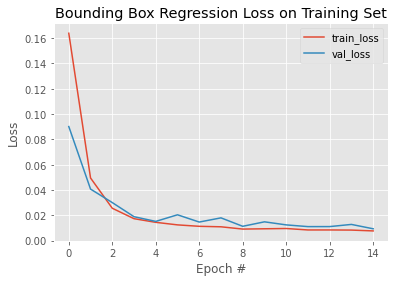

In [15]:
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, epoch_num), training.history["loss"], label="train_loss")
plt.plot(np.arange(0, epoch_num), training.history["val_loss"], label="val_loss")
plt.title("Bounding Box Regression Loss on Training Set")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="upper right")
#plt.show()
plt.savefig('./images/training1_20_1.png')